# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

plt.rcParams["figure.figsize"] = (21,14)

# Импорт датасетов

In [2]:
# csv
current_accounts = pd.read_csv(r'ВС DS Сбер data.csv', sep=';')

# xlsx
share_price_sber = pd.read_excel(r'Стоимость акций - SBER.xlsx', usecols=['Дата', 'Цена']) 
gold_price = pd.read_excel(r'золото-банк-россии.xlsx')

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    inflation_key_rate = pd.read_excel(r'Инфляция и ключевая ставка Банка России_F30_12_2013_T10_09_2019.xlsx', engine="openpyxl")
    ruble_exchange_rate = pd.read_excel(r'Курс валюты.xlsx', usecols='B:C', engine="openpyxl")

# Предобработка данных

In [3]:
current_accounts.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


In [4]:
current_accounts.REPORTDATE = pd.to_datetime(current_accounts.REPORTDATE, infer_datetime_format=True)
current_accounts.head()

,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149


In [5]:
share_price_sber.head()

,Дата,Цена
0,2019-10-10,228.50
1,2019-10-09,227.70
2,2019-10-08,226.03
3,2019-10-07,227.55
4,2019-10-04,222.76


In [6]:
share_price_sber.Дата = pd.to_datetime(share_price_sber.Дата, infer_datetime_format=True)
share_price_sber.head()

,Дата,Цена
0,2019-10-10,228.50
1,2019-10-09,227.70
2,2019-10-08,226.03
3,2019-10-07,227.55
4,2019-10-04,222.76


In [7]:
gold_price.head()

,Дата,Значение
0,2019-10-10,3146.52
1,2019-10-09,3128.29
2,2019-10-08,3130.78
3,2019-10-07,3156.00
4,2019-10-05,3156.00


In [8]:
inflation_key_rate.head()

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г"
0,2019-08-01 00:00:00,7.25,4.3
1,2019-07-01 00:00:00,7.25,4.6
2,2019-06-01 00:00:00,7.50,4.7
3,2019-05-01 00:00:00,7.75,5.1
4,2019-04-01 00:00:00,7.75,5.2


In [9]:
inflation_key_rate.Дата = pd.to_datetime(inflation_key_rate.Дата)
inflation_key_rate.head()

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г"
0,2019-08-01,7.25,4.3
1,2019-07-01,7.25,4.6
2,2019-06-01,7.50,4.7
3,2019-05-01,7.75,5.1
4,2019-04-01,7.75,5.2


In [10]:
ruble_exchange_rate.head()

,data,curs
0,2019-10-10,65.0976
1,2019-10-09,64.8672
2,2019-10-08,64.8259
3,2019-10-05,65.0300
4,2019-10-04,65.1312


## Объеднение данных

In [11]:
df = current_accounts.merge(share_price_sber, how='left', left_on='REPORTDATE', right_on='Дата')
df = df.merge(gold_price, how='left', left_on='REPORTDATE', right_on='Дата')
df = df.merge(inflation_key_rate, how='left', left_on='REPORTDATE', right_on='Дата')
df = df.merge(ruble_exchange_rate, how='left', left_on='REPORTDATE', right_on='data')
df.head()

,REPORTDATE,VALUE,Дата_x,Цена,Дата_y,Значение,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",data,curs
0,2013-12-30,3457625638,2013-12-30,101.17,2013-12-30,1268.53,NaT,NaN,NaN,NaT,NaN
1,2013-12-31,3417092149,NaT,NaN,2013-12-31,1264.30,NaT,NaN,NaN,2013-12-31,32.7292
2,2014-01-01,3417092149,NaT,NaN,2014-01-01,1261.58,2014-01-01,5.5,6.07,2014-01-01,32.6587
3,2014-01-02,3417092149,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaT,NaN
4,2014-01-03,3417092149,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaT,NaN


In [12]:
df = df.drop(['Дата_x', 'Дата_y', 'Дата', 'data'], axis=1)
df = df.rename(columns={'REPORTDATE': 'report_date', 'VALUE': 'funds_on_current_accounts', 'Цена': 'share_price_sber', 'Значение': 'gold_price', 'Ключевая ставка, % годовых': 'key_rate', 
                        'Инфляция, % г/г': 'inflation', 'curs': 'dollar_to_ruble_exchange_rate'})
df.head()

,report_date,funds_on_current_accounts,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate
0,2013-12-30,3457625638,101.17,1268.53,NaN,NaN,NaN
1,2013-12-31,3417092149,NaN,1264.30,NaN,NaN,32.7292
2,2014-01-01,3417092149,NaN,1261.58,5.5,6.07,32.6587
3,2014-01-02,3417092149,NaN,NaN,NaN,NaN,NaN
4,2014-01-03,3417092149,NaN,NaN,NaN,NaN,NaN


In [13]:
df.tail()

,report_date,funds_on_current_accounts,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate
2106,2019-10-06,64630140507,NaN,NaN,NaN,NaN,NaN
2107,2019-10-07,66115288637,227.55,3156.00,NaN,NaN,NaN
2108,2019-10-08,68424049766,226.03,3130.78,NaN,NaN,64.8259
2109,2019-10-09,72492897583,227.70,3128.29,NaN,NaN,64.8672
2110,2019-10-10,72307860851,228.50,3146.52,NaN,NaN,65.0976


# Заполнение пропусков

In [14]:
df = df.fillna(method='bfill')
df.head()

,report_date,funds_on_current_accounts,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate
0,2013-12-30,3457625638,101.17,1268.53,5.5,6.07,32.7292
1,2013-12-31,3417092149,98.91,1264.30,5.5,6.07,32.7292
2,2014-01-01,3417092149,98.91,1261.58,5.5,6.07,32.6587
3,2014-01-02,3417092149,98.91,1306.85,5.5,6.21,33.1547
4,2014-01-03,3417092149,98.91,1306.85,5.5,6.21,33.1547


In [15]:
df = df.fillna(method='ffill')
df.tail()

,report_date,funds_on_current_accounts,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate
2106,2019-10-06,64630140507,227.55,3156.00,7.25,4.3,64.8259
2107,2019-10-07,66115288637,227.55,3156.00,7.25,4.3,64.8259
2108,2019-10-08,68424049766,226.03,3130.78,7.25,4.3,64.8259
2109,2019-10-09,72492897583,227.70,3128.29,7.25,4.3,64.8672
2110,2019-10-10,72307860851,228.50,3146.52,7.25,4.3,65.0976


# Работа с датами

In [16]:
df["year"] = df.report_date.dt.year
df["month"] = df.report_date.dt.month
df["day"] = df.report_date.dt.day
df["day_of_week"] = df.report_date.dt.dayofweek
df["day_of_year"] = df.report_date.dt.dayofyear
df = df.drop(columns=['report_date'], axis=1)
df.head()

,funds_on_current_accounts,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate,year,month,day,day_of_week,day_of_year
0,3457625638,101.17,1268.53,5.5,6.07,32.7292,2013,12,30,0,364
1,3417092149,98.91,1264.30,5.5,6.07,32.7292,2013,12,31,1,365
2,3417092149,98.91,1261.58,5.5,6.07,32.6587,2014,1,1,2,1
3,3417092149,98.91,1306.85,5.5,6.21,33.1547,2014,1,2,3,2
4,3417092149,98.91,1306.85,5.5,6.21,33.1547,2014,1,3,4,3


# Разделение данных

In [17]:
X = df.drop('funds_on_current_accounts', axis=1)
y = df.funds_on_current_accounts

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1688, 10), (423, 10), (1688,), (423,))

# Обучение модели

In [19]:
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [20]:
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.9999081182342648


In [21]:
scores = cross_val_score(xgbr, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 1.00


In [22]:
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("MAE: %.2f" % mae)

MSE: 1595571132885687040.00
RMSE: 1263159187.47
MAE: 769500025.65


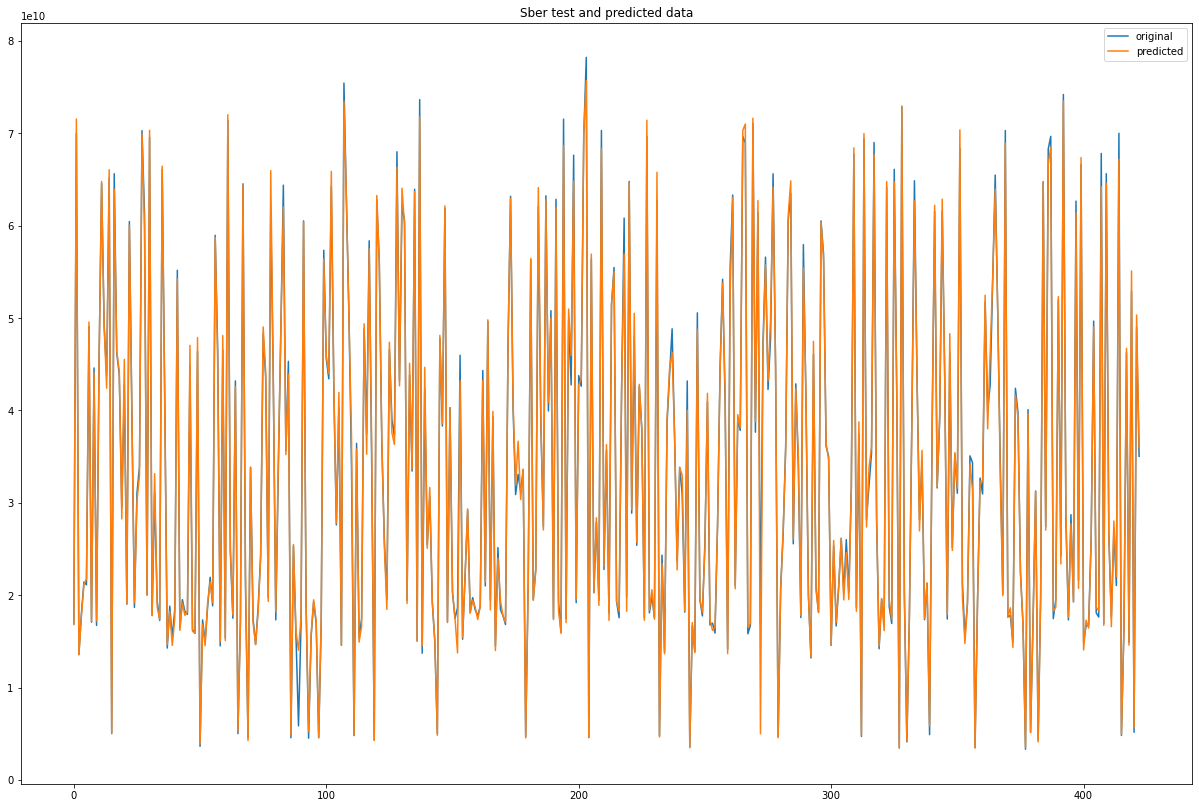

In [23]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Sber test and predicted data")
plt.legend()
plt.show()

# Быстрая обработка значений для предсказаний 

In [24]:
# csv
share_price_sber_pred = pd.read_csv(r'Стоимость акций - SBER_предсказание.csv', sep=';')

# xlsx
data_pred = pd.read_excel(r'даты_предсказание.xlsx')
gold_price_pred = pd.read_excel(r'золото-банк-россии_предсказание.xlsx')

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    inflation_key_rate_pred = pd.read_excel(r'Инфляция и ключевая ставка Банка России_предсказание.xlsx', engine="openpyxl")
    ruble_exchange_rate_pred = pd.read_excel(r'Курс валюты_предсказание.xlsx', engine="openpyxl")

In [25]:
share_price_sber_pred.Data = pd.to_datetime(share_price_sber_pred.Data, format='%d.%m.%Y')
share_price_sber_pred.head()

,Data,share_price_sber
0,2021-10-01,338.48
1,2021-09-30,340.99
2,2021-09-29,328.43
3,2021-09-28,329.30
4,2021-09-27,331.68


In [26]:
data_pred.REPORTDATE = pd.to_datetime(data_pred.REPORTDATE, format='%d.%m.%Y')
data_pred.head()

,REPORTDATE
0,2019-10-11
1,2019-10-12
2,2019-10-13
3,2019-10-14
4,2019-10-15


In [27]:
gold_price_pred.head()

,Дата,gold_price
0,2021-10-01,4043.86
1,2021-09-30,4074.26
2,2021-09-29,4055.46
3,2021-09-28,4086.21
4,2021-09-27,4119.80


In [28]:
inflation_key_rate_pred.Дата = pd.to_datetime(inflation_key_rate_pred.Дата)
inflation_key_rate_pred.tail()

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г"
19,2020-02-01,6.00,2.3
20,2020-01-01,6.25,2.4
21,2019-12-01,6.25,3.0
22,2019-11-01,6.50,3.5
23,2019-10-01,6.50,3.8


In [29]:
ruble_exchange_rate_pred.head()

,data,dollar_to_ruble_exchange_rate
0,2021-10-01,72.6642
1,2021-09-30,72.7608
2,2021-09-29,72.5083
3,2021-09-28,72.6613
4,2021-09-25,73.0081


In [30]:
data_pred.shape

(722, 1)

In [31]:
data_pred.REPORTDATE.iloc[-1] - data_pred.REPORTDATE.iloc[0]

Timedelta('721 days 00:00:00')

In [32]:
df_pred = data_pred.merge(share_price_sber_pred, how='left', left_on='REPORTDATE', right_on='Data')
df_pred = df_pred.merge(gold_price_pred, how='left', left_on='REPORTDATE', right_on='Дата')
df_pred = df_pred.merge(inflation_key_rate_pred, how='left', left_on='REPORTDATE', right_on='Дата')
df_pred = df_pred.merge(ruble_exchange_rate_pred, how='left', left_on='REPORTDATE', right_on='data')
df_pred.head()

,REPORTDATE,Data,share_price_sber,Дата_x,gold_price,Дата_y,"Ключевая ставка, % годовых","Инфляция, % г/г",data,dollar_to_ruble_exchange_rate
0,2019-10-11,2019-10-11,230.31,2019-10-11,3139.30,NaT,NaN,NaN,2019-10-11,64.7416
1,2019-10-12,NaT,NaN,2019-10-12,3093.85,NaT,NaN,NaN,2019-10-12,64.2237
2,2019-10-13,NaT,NaN,NaT,NaN,NaT,NaN,NaN,NaT,NaN
3,2019-10-14,2019-10-14,228.40,2019-10-14,3093.85,NaT,NaN,NaN,NaT,NaN
4,2019-10-15,2019-10-15,229.40,2019-10-15,3092.08,NaT,NaN,NaN,2019-10-15,64.3652


In [33]:
df_pred.REPORTDATE.value_counts()

2021-05-14    2
2021-05-28    2
2021-05-19    2
2021-05-20    2
2021-05-13    2
             ..
2020-06-09    1
2020-06-10    1
2020-06-11    1
2020-06-12    1
2021-10-01    1
Name: REPORTDATE, Length: 722, dtype: int64

In [34]:
df_pred = df_pred.drop_duplicates(subset='REPORTDATE')

In [35]:
df_pred.shape

(722, 10)

In [36]:
df_pred.tail()

,REPORTDATE,Data,share_price_sber,Дата_x,gold_price,Дата_y,"Ключевая ставка, % годовых","Инфляция, % г/г",data,dollar_to_ruble_exchange_rate
732,2021-09-27,2021-09-27,331.68,2021-09-27,4119.80,NaT,NaN,NaN,NaT,NaN
733,2021-09-28,2021-09-28,329.30,2021-09-28,4086.21,NaT,NaN,NaN,2021-09-28,72.6613
734,2021-09-29,2021-09-29,328.43,2021-09-29,4055.46,NaT,NaN,NaN,2021-09-29,72.5083
735,2021-09-30,2021-09-30,340.99,2021-09-30,4074.26,NaT,NaN,NaN,2021-09-30,72.7608
736,2021-10-01,2021-10-01,338.48,2021-10-01,4043.86,NaT,NaN,NaN,2021-10-01,72.6642


# Предсказание с 11.10.2019г. по 1.10.2021

In [37]:
df_pred = df_pred.drop(['Дата_x', 'Дата_y', 'Data', 'data'], axis=1)
df_pred = df_pred.rename(columns={'REPORTDATE': 'report_date', 'Ключевая ставка, % годовых': 'key_rate', 'Инфляция, % г/г': 'inflation'})

In [38]:
df_pred.shape

(722, 6)

In [39]:
df_pred = df_pred.fillna(method='bfill')
df_pred.head()

,report_date,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate
0,2019-10-11,230.31,3139.30,6.5,3.5,64.7416
1,2019-10-12,228.40,3093.85,6.5,3.5,64.2237
2,2019-10-13,228.40,3093.85,6.5,3.5,64.3652
3,2019-10-14,228.40,3093.85,6.5,3.5,64.3652
4,2019-10-15,229.40,3092.08,6.5,3.5,64.3652


In [40]:
df_pred = df_pred.fillna(method='ffill')
df_pred.tail()

,report_date,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate
732,2021-09-27,331.68,4119.80,6.75,7.4,72.6613
733,2021-09-28,329.30,4086.21,6.75,7.4,72.6613
734,2021-09-29,328.43,4055.46,6.75,7.4,72.5083
735,2021-09-30,340.99,4074.26,6.75,7.4,72.7608
736,2021-10-01,338.48,4043.86,6.75,7.4,72.6642


In [41]:
df_pred["year"] = df_pred.report_date.dt.year
df_pred["month"] = df_pred.report_date.dt.month
df_pred["day"] = df_pred.report_date.dt.day
df_pred["day_of_week"] = df_pred.report_date.dt.dayofweek
df_pred["day_of_year"] = df_pred.report_date.dt.dayofyear
df_pred = df_pred.drop(columns=['report_date'], axis=1)
df_pred.head()

,share_price_sber,gold_price,key_rate,inflation,dollar_to_ruble_exchange_rate,year,month,day,day_of_week,day_of_year
0,230.31,3139.30,6.5,3.5,64.7416,2019,10,11,4,284
1,228.40,3093.85,6.5,3.5,64.2237,2019,10,12,5,285
2,228.40,3093.85,6.5,3.5,64.3652,2019,10,13,6,286
3,228.40,3093.85,6.5,3.5,64.3652,2019,10,14,0,287
4,229.40,3092.08,6.5,3.5,64.3652,2019,10,15,1,288


In [42]:
df_pred.shape

(722, 10)

In [43]:
new_pred = xgbr.predict(df_pred)

In [44]:
len(new_pred)

722

In [45]:
index = data_pred.REPORTDATE
pred = pd.DataFrame({"Date": index, "funds_on_current_accounts": new_pred})
pred.head()

,Date,funds_on_current_accounts
0,2019-10-11,6.245623e+10
1,2019-10-12,6.244250e+10
2,2019-10-13,6.255188e+10
3,2019-10-14,6.135614e+10
4,2019-10-15,6.012047e+10


In [46]:
pred['day'] = pred.Date.dt.day
pred.head()

,Date,funds_on_current_accounts,day
0,2019-10-11,6.245623e+10,11
1,2019-10-12,6.244250e+10,12
2,2019-10-13,6.255188e+10,13
3,2019-10-14,6.135614e+10,14
4,2019-10-15,6.012047e+10,15


# Создание отдельного датасета с стабильной частью на каждый месяц первого числа

In [47]:
stable_value = pred[pred['day'] == 1]
stable_value = stable_value.drop(columns=['day'], axis=1)
stable_value.head()

,Date,funds_on_current_accounts
21,2019-11-01,5.499099e+10
51,2019-12-01,5.548386e+10
82,2020-01-01,4.707380e+10
113,2020-02-01,5.392619e+10
142,2020-03-01,5.106761e+10


<AxesSubplot:xlabel='Date', ylabel='funds_on_current_accounts'>

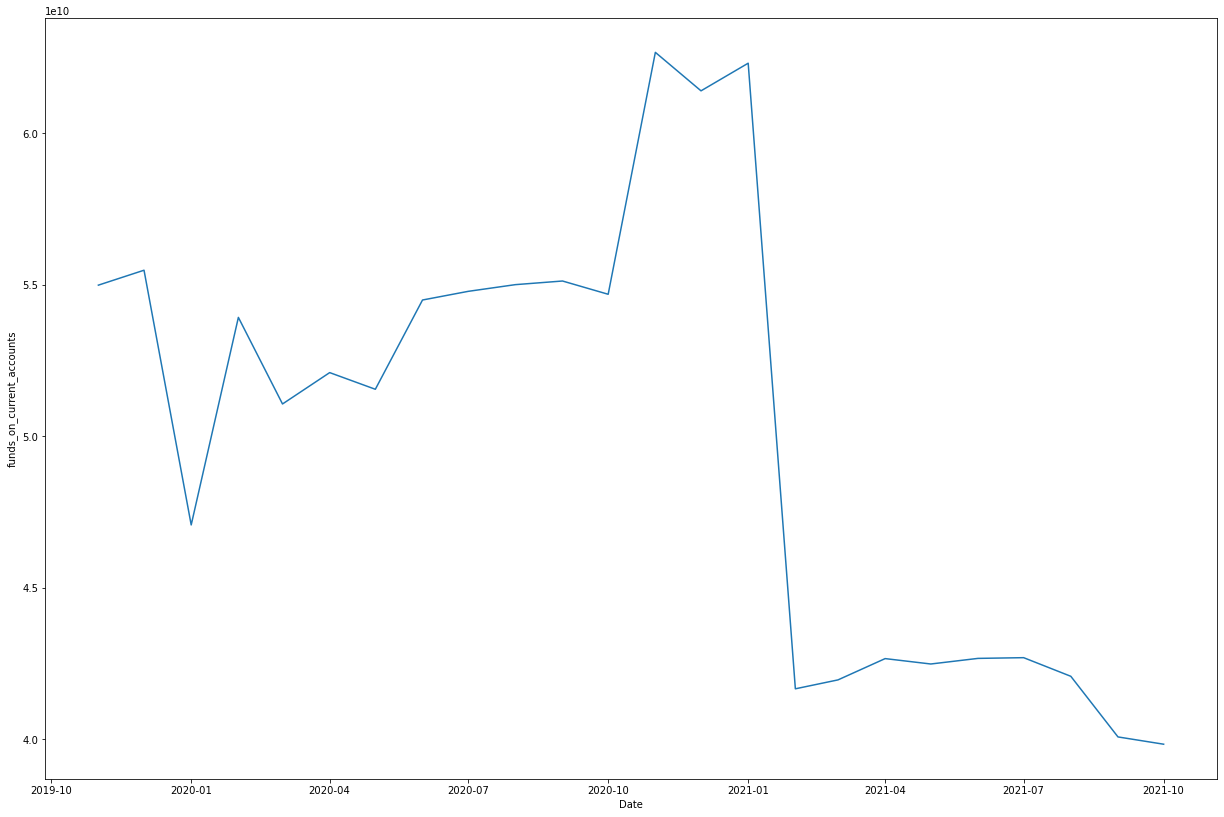

In [48]:
sns.lineplot(x=stable_value.Date, y=stable_value.funds_on_current_accounts)

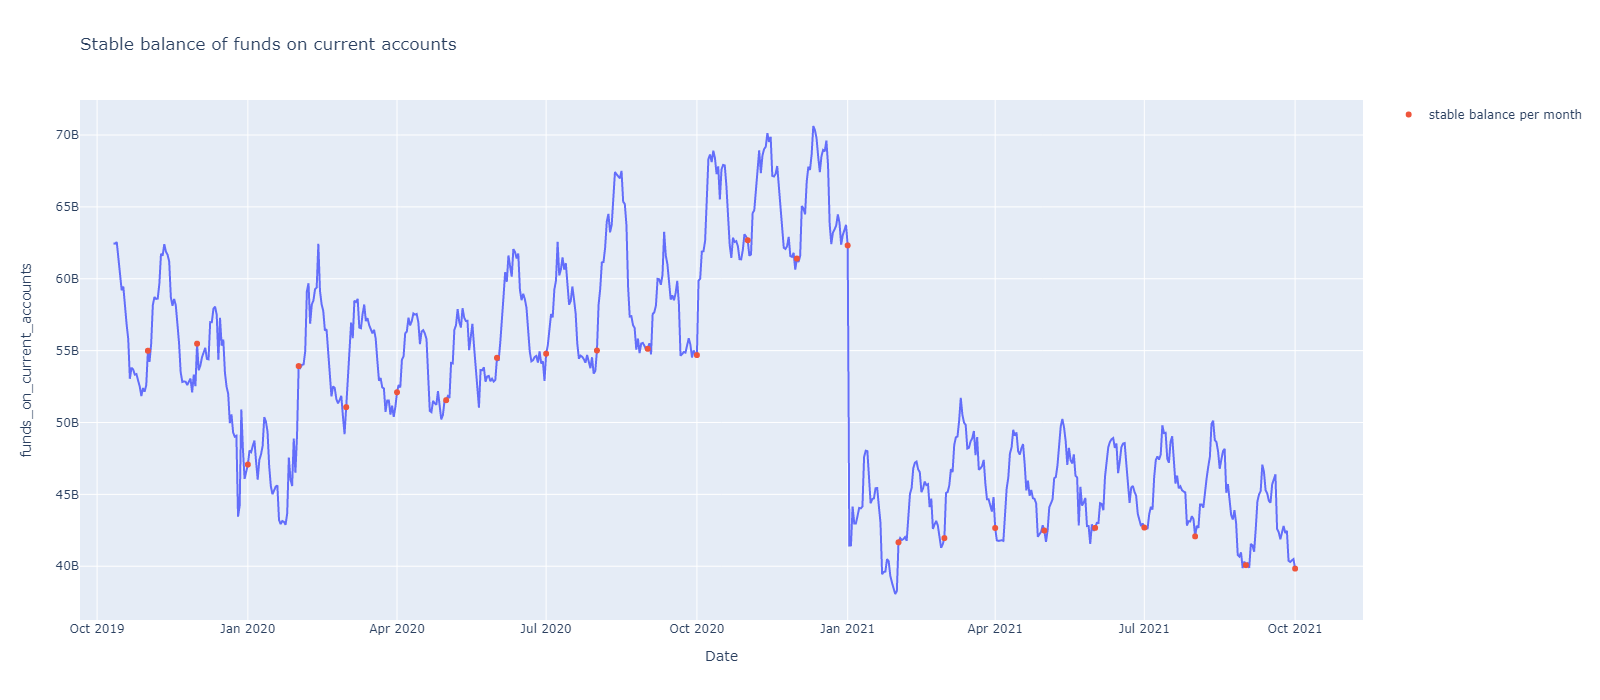

In [56]:
fig = px.line(pred, x="Date", y="funds_on_current_accounts", title='Stable balance of funds on current accounts',  width=1600, height=700)
fig.add_trace(go.Scatter(x=stable_value['Date'], y=stable_value['funds_on_current_accounts'],
                    mode='markers', name='stable balance per month'))
fig.show('png')